In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


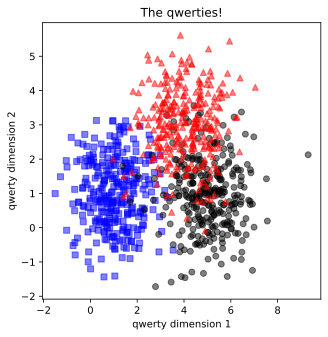

In [2]:
n_per_clust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 3]

a = [ A[0]+np.random.randn(n_per_clust)*blur, A[1]+np.random.randn(n_per_clust)*blur ]
b = [ B[0]+np.random.randn(n_per_clust)*blur, B[1]+np.random.randn(n_per_clust)*blur ]
c = [ C[0]+np.random.randn(n_per_clust)*blur, C[1]+np.random.randn(n_per_clust)*blur ]

labels_np = np.hstack(( np.zeros((n_per_clust)),
                        np.ones((n_per_clust)),
                      1+np.ones((n_per_clust))))

data_np = np.hstack((a,b,c)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.1)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 16
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [4]:
def create_model(optimizer_algo):
    class ANN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(2,8)
            
            self.fc1 = nn.Linear(8,8)
            
            self.output = nn.Linear(8,3)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
        
    model = ANN()
    
    loss_fun = nn.CrossEntropyLoss()
    optimizer= getattr(torch.optim, optimizer_algo)(model.parameters(), lr=.01)
    
    return model, loss_fun, optimizer

In [5]:
optim = create_model('RMSprop')[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

In [6]:
num_of_epochs = 50
def train_model(optimizer_algo):
 
    
    model, loss_fun, optimizer = create_model(optimizer_algo)
    
    losses = torch.zeros(num_of_epochs)
    train_acc = []
    test_acc = []
    
    for epoch in range(num_of_epochs):
        model.train()
        
        batch_acc = []
        batch_loss = []
        for X,y in train_loader:
            yHat = model(X)
            loss = loss_fun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            matches = torch.argmax(yHat, axis=1) == y
            matches_numeric = matches.float()
            accuracy = 100*torch.mean(matches_numeric)
            batch_acc.append(accuracy)
        train_acc.append(np.mean(batch_acc))
        
        losses[epoch] = np.mean(batch_loss)
        
        model.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = model(X)
            
        test_acc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))    
        
    return train_acc, test_acc, losses, model

In [7]:
def plot_the_results(optimizer_type):
    yHat = model(data)
    predictions = torch.argmax(yHat, axis=1)
    accuracy = (predictions == labels).float()
    total_acc = torch.mean(100*accuracy).item()
    
    accuracy_by_group = np.zeros(3)
    for i in range(3):
        accuracy_by_group[i] = 100*torch.mean(accuracy[labels==i])
        
    fig, ax = plt.subplots(2,2, figsize=(10,6))
    
    ax[0,0].plot(losses.detach())
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_xlabel('epoch')
    ax[0,0].set_title(f"{optimizer_type}: Losses")
    
    ax[0,1].plot(train_acc, label='Train')
    ax[0,1].plot(test_acc, label='Test')
    ax[0,1].set_ylabel('Accuracy (%)')
    ax[0,1].set_xlabel('Epoch')
    ax[0,1].set_title(f"{optimizer_type}: Accuracy")
    ax[0,1].legend()
    
    ax[1,0].bar(range(3), accuracy_by_group)
    ax[1,0].set_ylim([np.min(accuracy_by_group)-5,np.max(accuracy_by_group)+5])
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_xlabel('Group')
    ax[1,0].set_ylabel('Accuracy (%)')
    ax[1,0].set_title(f"{optimizer_type}: Accuracy by group")
    
    color_shapes = ["bs","ko", "g^"]
    for i in range(3):
        ax[1,1].plot(data[labels==i,0],data[labels==i,1],color_shapes[i],alpha=.3,label=f"Group {i}")
        idx_err = (accuracy==0) & (labels==i)
        ax[1,1].plot(data[idx_err,0],data[idx_err,1],'rx')
    
    ax[1,1].set_title(f"{optimizer_type}: Total accuracy: {total_acc:.2f}%")
    ax[1,1].set_xlabel("Dimension 1")
    ax[1,1].set_ylabel("Dimension 2")
    ax[1,1].legend()
    
    plt.tight_layout()
    plt.show()

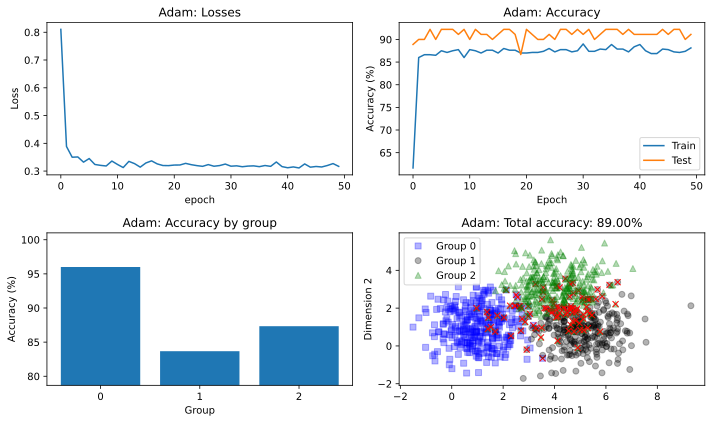

In [8]:
optimizer_type = 'Adam'
train_acc, test_acc, losses, model = train_model(optimizer_type)

plot_the_results(optimizer_type)

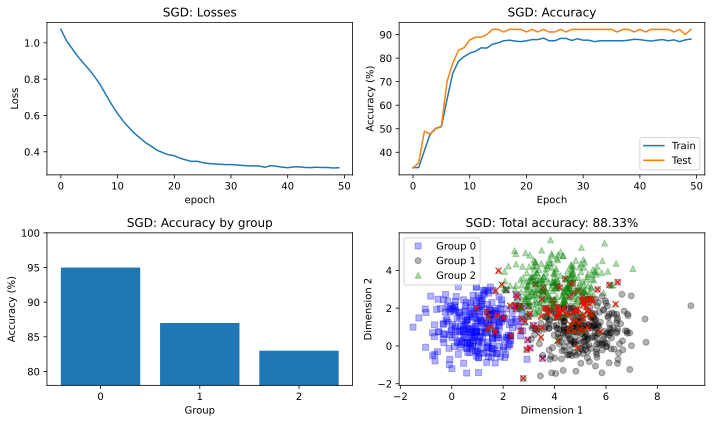

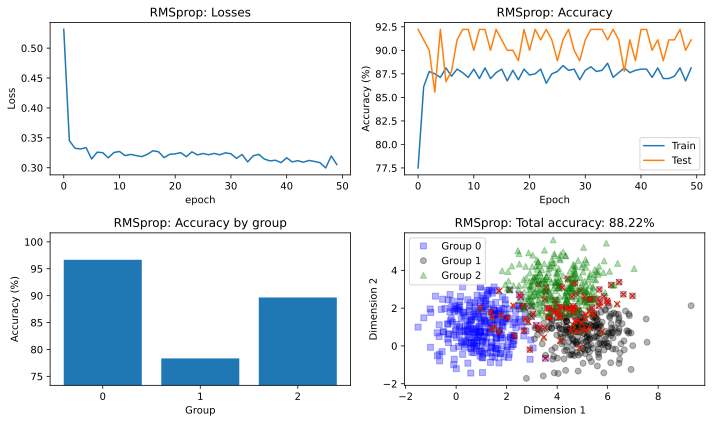

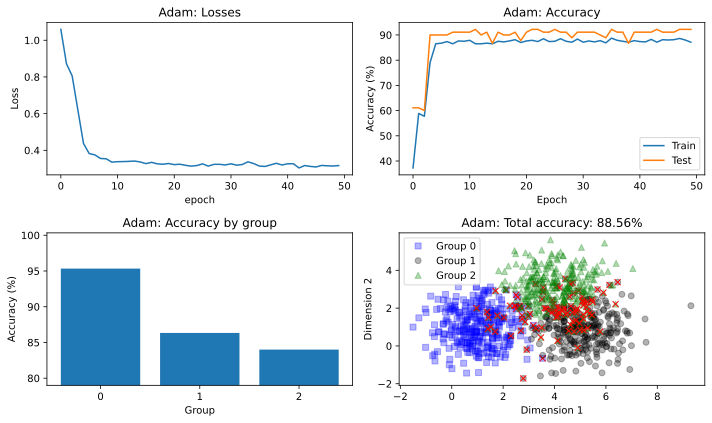

In [9]:
performance = []

for opto in ['SGD', 'RMSprop', 'Adam']:
    train_acc, test_acc, losses, model = train_model(opto)
    plot_the_results(opto)
    
    train = np.mean(train_acc[-10:])
    test = np.mean(test_acc[-10:])
    
    performance.append(f"{opto}: train {train:.1f}%, test {test:.1f}%")

In [10]:
performance

['SGD: train 87.6%, test 91.8%',
 'RMSprop: train 87.6%, test 91.0%',
 'Adam: train 87.8%, test 91.6%']